# Training the CNN

## Loading the data
If this notebook runs the first time, the data has to be loaded by setting 
```load_data``` to ```True```

In [1]:
load_data=True
if load_data:
    !mkdir /data
    !wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
    !unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2018-11-27 16:37:46--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.165.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.165.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.4’

train-test-data.zip 100%[===================>] 322.93M  54.2MB/s    in 5.5s    

2018-11-27 16:37:52 (58.5 MB/s) - ‘/data/train-test-data.zip.4’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

## Loading the Py Torch CNN

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# import a model that has previously been defined in an external file
from models import Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2)
  (fc4): Linear(in_features=4096, out_features=500, bias=True)
  (batchnorm4): BatchNorm1d(500, eps=1e-05, momentum=0

## Transforming the dataset 

To prepare for training, one creates a transformed dataset of images and keypoints.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


# Define the data_transform using transforms.Compose([all tx's, . , .])
data_transform = transforms.Compose([Rescale((224,224)), Normalize(),ToTensor()])

# testing that a transform has been defined
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Predicting keypoints
Next a function is defined to pass a batch of images through the model and return a a sample of the the predicted key points 



In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        net.eval()
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

## Training the CNN

#### Loss function
ADAM as defined as the optimizer and the Lossfunction is chosen to be SmoothL1 loss. Then the network is trained on the loaded data.

In [10]:
## Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss() # alternative: nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)


In [11]:
#Define a function that performs training of the CNN
# The progress is saved in a checkpoint file
import time
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        print('Started Training')
        for batch_i, data in enumerate(train_loader):
            time0=time.time()
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images  = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)
            output_pts = output_pts.type(torch.FloatTensor)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
                torch.save(net.state_dict(), 'checkpoint.pth')
            if batch_i==0:   
                timer=time.time()-time0
                print('Required Minutes::','%.2f' %(0.0167*timer*len(train_loader)+n_epochs))
    print('Finished Training')


### Training the network
Set ``` do_train``` to ```True``` to train the network. Once this is done, it can be set to False because the network is loaded from the checkpoint file after this. It takes at least 10 epochs ith the current settings to get reasonable results.

In [12]:
# train the CNN
do_train = False
n_epochs = 10

if do_train:
    with active_session():
        train_net(n_epochs)
    # After training save weights to designated folder
    model_dir = 'saved_models/'
    model_name = 'model_1.pth'
    torch.save(net.state_dict(), model_dir+model_name)

## Visualize the predicted keypoints

First two helper functions have to be defined. The first one is meant to plot the keypoints on top of the corresponding picture

In [13]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

The second function takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data, and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors and it undoes the keypoint normalization done in the Normalize() transform;

In [14]:
# visualize the output
# by default this shows a batch of 4 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=4):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

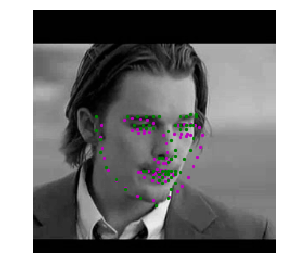

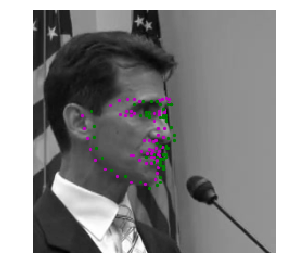

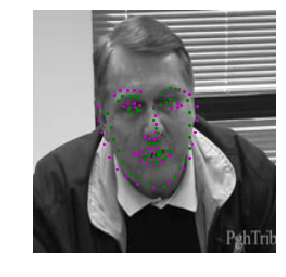

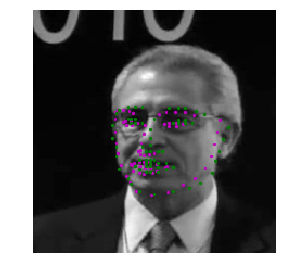

In [15]:
# load weights from file
state_dict = torch.load('saved_models/model_1.pth')
net.load_state_dict(state_dict)

# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

visualize_output(test_images, test_outputs, gt_pts,batch_size=4)

## Feature Visualization
Finally one can plot filters from the CNN and their effect on images to understand the nettwork abit better. THe filter is chpsen from the first layer and can be changed through the value of ```filter_index```


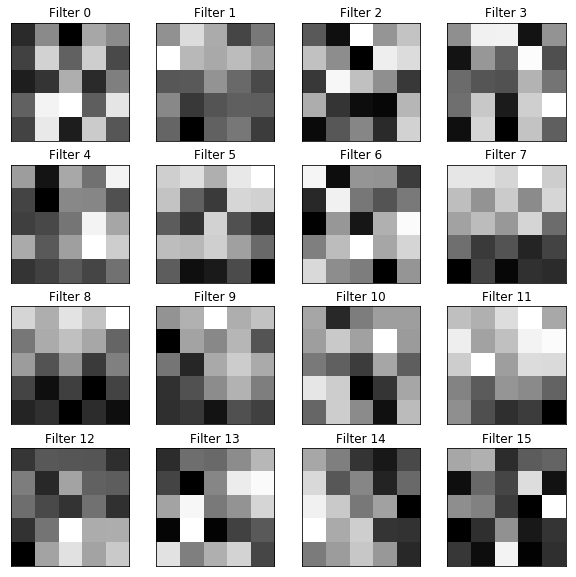

In [18]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer

w = weights1.numpy()
fig = plt.figure(figsize=(10, 10))
for i in range(len(weights1)):
    fltr = w[i][0]
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(fltr, cmap='gray')
    ax.set_title('Filter %s' % str(i))  

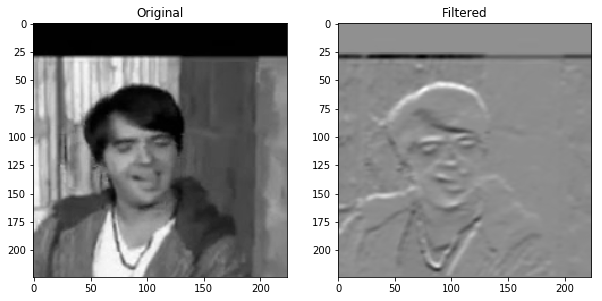

In [20]:
##load in and display any image from the transformed test dataset
import cv2
image = transformed_dataset[0]['image'].data.numpy()
image = np.transpose(image, (1, 2, 0))
image = np.squeeze(image)
image=image*255

## Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
fltr_no=7
fltr = w[fltr_no][0]
filtered_image = cv2.filter2D(image, -1, fltr)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_title('Original')
ax1.imshow(image, cmap='gray')
ax2.set_title('Filtered')
ax2.imshow(filtered_image, cmap='gray')

The filter used for the example above clearly is an edge detector for horizontal edges.